# 0. Overview

## 0.1 Versions
 - ClassEffb0_001<br>
 Baseline Model<br>
 - ClassEffb0_002<br>
 16 Fold, Weight 1-1 Pos-Neg


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, cv2, time, random
from tqdm import tqdm, tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import albumentations as albu


In [2]:
N_SPLITS = 16
SEED = 1234
FOLD = 0
CLOUD_TYPE = 'Flower'
VERSION = f'ClassEffb0_{CLOUD_TYPE}-6'
PREVIOUS_VERSION = f'ClassEffb0_{CLOUD_TYPE}-5'
PATH = '../input'
TRAIN_PATH = '../input/train_images_525/train_images_525'
TEST_PATH = '../input/test_images_525/test_images_525' 
TRAIN_MASK_PATH = '../input/train_masks_525/train_masks_525'
WEIGHT_PATH = '../input/weights'
SUBMISSION_PATH = '../input/submissions'
N_JOBS = 7

DEVICE_NUM=1
DEVICE = torch.device(f"cuda:{DEVICE_NUM}" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(DEVICE_NUM) 
train_on_gpu = torch.cuda.is_available()

IMAGE_SIZE = (1400, 2100)
IMAGE_SIZE_525 = (350, 525)

In [3]:
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# 1. Preparation

## 1.1 Load Datasets

In [4]:
train_df = pd.read_csv(PATH+f'/pseudo_{CLOUD_TYPE}_{PREVIOUS_VERSION}.csv')
train_df.head()

,path,hasMask,from
0,../input/resized_images/train_images_525/00111...,1,train
1,../input/resized_images/train_images_525/002be...,1,train
2,../input/resized_images/train_images_525/0031a...,1,train
3,../input/resized_images/train_images_525/00352...,1,train
4,../input/resized_images/train_images_525/00399...,0,train


In [5]:
sub_df = pd.read_csv(PATH+f'/pseudo_test_{CLOUD_TYPE}_{PREVIOUS_VERSION}.csv')
sub_df.head()

,path
0,../input/resized_images/test_images_525/003832...
1,../input/resized_images/test_images_525/006440...
2,../input/resized_images/test_images_525/0078e5...
3,../input/resized_images/test_images_525/008fc8...
4,../input/resized_images/test_images_525/00a717...


## 1.2 Split Data

In [6]:
ids = train_df.index.values

train_idx, val_idx = train_test_split(ids, test_size=1/N_SPLITS, random_state=SEED)

train_paths = np.array(train_df['path'].iloc[train_idx])
val_paths = np.array(train_df['path'].iloc[val_idx])
test_paths = sub_df["path"].values

## 1.3 Data Generator

In [7]:
def get_training_augmentation():
    train_transform = [
        albu.OneOf([
           albu.Resize(320, 480),
           albu.RandomCrop(height=320, width=480),
           ], p=1),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.1),
        albu.Rotate(limit=20,p=0.3),
        albu.GaussNoise(p=0.2),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.3, border_mode=0),
        albu.GridDistortion(p=0.1),
#         albu.OpticalDistortion(p=0.1, distort_limit=2, shift_limit=0.5),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 480),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(test_transform)

def get_test_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 480),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(test_transform)

In [8]:
# Dataset class
class CloudDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame = None,
        datatype: str = "train",
        img_ids: np.array = None,
        transforms = transforms,
    ):
        self.df = df
        self.datatype = datatype
        self.img_ids = img_ids
        self.transforms = transforms

        
    def __getitem__(self, idx):
        
        image_path = self.img_ids[idx]
        
        if self.datatype != "test":
            y = self._find_target(image_path)
            y = torch.Tensor(y)
        
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img)
        img = np.transpose(augmented["image"], [2, 0, 1])
        
        if self.datatype != "test":
            return img, y
        else:
            return img
    
    def _find_target(self, image_name):
        df_target = self.df[self.df['path'] == image_name]
        y = df_target['hasMask'].values
        return y

    def __len__(self):
        return len(self.img_ids)

## 1.4 Optimizer

In [9]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

# 2. Modeling

## 2.1 Model Definition

In [10]:
num_workers = N_JOBS
batch_size = 16

train_dataset = CloudDataset(df=train_df,
                             datatype="train",
                             img_ids=train_paths,
                             transforms=get_training_augmentation(),)

valid_dataset = CloudDataset(df=train_df,
                             datatype="valid",
                             img_ids=val_paths,
                             transforms=get_validation_augmentation(),)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=num_workers)

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=num_workers)

In [11]:
from efficientnet_pytorch import EfficientNet
import torch.nn.functional as F

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1)
model._fc = nn.Sequential(
    nn.Linear(in_features=1280, out_features=1, bias=True),
    nn.Sigmoid()
)
if train_on_gpu:
    model.to(DEVICE)
    
# model

Loaded pretrained weights for efficientnet-b0


In [12]:
criterion = torch.nn.BCELoss()
# optimizer = RAdam(model.parameters(), lr=0.04)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, cooldown=2, verbose=True)


## 2.2 Training Starts Here

In [13]:
# number of epochs to train the model
n_epochs = 30

train_loss_list = []
train_roc_auc_list = []
valid_loss_list = []
valid_roc_auc_list = []

lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
batch_multiplier = 8
model.to(DEVICE)

torch.backends.cudnn.benchmark = True

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_roc_auc = 0.0
    valid_roc_auc = 0.0
    count = 0  #multiple minibatch
    
    ###################
    # train the model #
    ###################
    model.train()
    bar = tqdm(train_loader, postfix={"train_loss":0.0,"train_roc_auc":0.0})
    for data, target in bar:
        # move tensors to GPU if CUDA is available
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        if count == 0:
            optimizer.step()
            optimizer.zero_grad()
            count = batch_multiplier
        
        # forward pass: compute predicted outputs by passing inputs to the model   
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target) / batch_multiplier
        loss.backward()
        
        # perform a single optimization step (parameter update)
        #optimizer.step()
        
        if count == batch_multiplier:
            try:
                roc_auc_    = roc_auc_score(targets, outputs)
                train_roc_auc += roc_auc_ * data.size(0) * batch_multiplier
            except:
                pass
            targets = target.to("cpu").data.numpy()
            outputs = output.to("cpu").data.numpy()
        
        targets = np.vstack([targets, target.to("cpu").data.numpy()])
        outputs = np.vstack([outputs, output.to("cpu").data.numpy()])
        # update training loss
        train_loss += loss.item() * data.size(0) * batch_multiplier
        
        count -= 1  #multiple minibatch

        try:
            bar.set_postfix(ordered_dict={"train_loss":loss.item() * batch_multiplier, "train_roc_auc":roc_auc_})
        except:
            pass
        
    try:
        roc_auc_    = roc_auc_score(targets, outputs)
        train_roc_auc += roc_auc_ * data.size(0) * batch_multiplier
    except:
        pass
        
    ######################
    # validate the model #
    ######################
    model.eval()
    
    del data, target, targets, outputs

    with torch.no_grad():

        bar = tqdm(valid_loader, postfix={"valid_loss":0.0, "roc_auc_score":0.0})
        count = batch_multiplier
        
        for data, target in bar:
            
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
                
            if count == 0:
                count = batch_multiplier
                
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            
            if count == batch_multiplier:
                try:
                    roc_auc_    = roc_auc_score(targets, outputs)
                    valid_roc_auc += roc_auc_ * data.size(0) * batch_multiplier
                except:
                    pass
                targets = target.to("cpu").data.numpy()
                outputs = output.to("cpu").data.numpy()
                
            targets = np.vstack([targets, target.to("cpu").data.numpy()])
            outputs = np.vstack([outputs, output.to("cpu").data.numpy()])
            
            try:
                bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "roc_auc_score":roc_auc_})
            except:
                pass
            
            count -= 1
            
        try:
            roc_auc_    = roc_auc_score(targets, outputs)
            valid_roc_auc += roc_auc_ * data.size(0) * batch_multiplier
        except:
            pass
        
    del data, target, targets, outputs
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    train_roc_auc = train_roc_auc/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    valid_roc_auc = valid_roc_auc/len(valid_loader.dataset)
    
    train_loss_list.append(train_loss)
    train_roc_auc_list.append(train_roc_auc)
    valid_loss_list.append(valid_loss)
    valid_roc_auc_list.append(valid_roc_auc)

    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {} || Training Loss: {:.6f}  Training Auc Roc Score: {:.6f} || Validation Loss: {:.6f} Auc Roc Score: {:.6f}'.format(
          epoch, train_loss, train_roc_auc, valid_loss, valid_roc_auc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), f"{WEIGHT_PATH}/model_{VERSION}_best.pth")
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)
    

  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 1 || Training Loss: 0.562706  Training Auc Roc Score: 0.770684 || Validation Loss: 0.298307 Auc Roc Score: 1.080785
Validation loss decreased (inf --> 0.298307).  Saving model ...


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 2 || Training Loss: 0.443881  Training Auc Roc Score: 0.865911 || Validation Loss: 0.267392 Auc Roc Score: 1.088059
Validation loss decreased (0.298307 --> 0.267392).  Saving model ...


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 3 || Training Loss: 0.423577  Training Auc Roc Score: 0.879950 || Validation Loss: 0.273905 Auc Roc Score: 1.088636


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 4 || Training Loss: 0.409845  Training Auc Roc Score: 0.889275 || Validation Loss: 0.254228 Auc Roc Score: 1.091669
Validation loss decreased (0.267392 --> 0.254228).  Saving model ...


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 5 || Training Loss: 0.407877  Training Auc Roc Score: 0.891726 || Validation Loss: 0.249193 Auc Roc Score: 1.093368
Validation loss decreased (0.254228 --> 0.249193).  Saving model ...


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 6 || Training Loss: 0.389382  Training Auc Roc Score: 0.902140 || Validation Loss: 0.250374 Auc Roc Score: 1.094081


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 7 || Training Loss: 0.392102  Training Auc Roc Score: 0.901657 || Validation Loss: 0.243834 Auc Roc Score: 1.094924
Validation loss decreased (0.249193 --> 0.243834).  Saving model ...


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 8 || Training Loss: 0.383607  Training Auc Roc Score: 0.905059 || Validation Loss: 0.240336 Auc Roc Score: 1.095703
Validation loss decreased (0.243834 --> 0.240336).  Saving model ...


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 9 || Training Loss: 0.372897  Training Auc Roc Score: 0.912904 || Validation Loss: 0.236080 Auc Roc Score: 1.096849
Validation loss decreased (0.240336 --> 0.236080).  Saving model ...


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 10 || Training Loss: 0.374229  Training Auc Roc Score: 0.910938 || Validation Loss: 0.260756 Auc Roc Score: 1.094401


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 11 || Training Loss: 0.356288  Training Auc Roc Score: 0.921038 || Validation Loss: 0.247340 Auc Roc Score: 1.093329


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 12 || Training Loss: 0.363672  Training Auc Roc Score: 0.919313 || Validation Loss: 0.243167 Auc Roc Score: 1.094631


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 13 || Training Loss: 0.361434  Training Auc Roc Score: 0.917653 || Validation Loss: 0.253204 Auc Roc Score: 1.093968
Epoch    12: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 14 || Training Loss: 0.348120  Training Auc Roc Score: 0.924580 || Validation Loss: 0.242545 Auc Roc Score: 1.094280


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 15 || Training Loss: 0.345578  Training Auc Roc Score: 0.925447 || Validation Loss: 0.245169 Auc Roc Score: 1.094173


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 16 || Training Loss: 0.339429  Training Auc Roc Score: 0.928465 || Validation Loss: 0.248353 Auc Roc Score: 1.093033


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 17 || Training Loss: 0.339002  Training Auc Roc Score: 0.928140 || Validation Loss: 0.249861 Auc Roc Score: 1.092998


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 18 || Training Loss: 0.343557  Training Auc Roc Score: 0.926917 || Validation Loss: 0.246624 Auc Roc Score: 1.093506


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 19 || Training Loss: 0.327543  Training Auc Roc Score: 0.934835 || Validation Loss: 0.247508 Auc Roc Score: 1.094268
Epoch    18: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 20 || Training Loss: 0.336316  Training Auc Roc Score: 0.930494 || Validation Loss: 0.249964 Auc Roc Score: 1.094230


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 21 || Training Loss: 0.319512  Training Auc Roc Score: 0.937338 || Validation Loss: 0.249387 Auc Roc Score: 1.092828


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 22 || Training Loss: 0.327138  Training Auc Roc Score: 0.935570 || Validation Loss: 0.248630 Auc Roc Score: 1.093159


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 23 || Training Loss: 0.336229  Training Auc Roc Score: 0.930552 || Validation Loss: 0.248971 Auc Roc Score: 1.093549


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 24 || Training Loss: 0.324565  Training Auc Roc Score: 0.934899 || Validation Loss: 0.251563 Auc Roc Score: 1.092609


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 25 || Training Loss: 0.322251  Training Auc Roc Score: 0.935590 || Validation Loss: 0.248955 Auc Roc Score: 1.092939
Epoch    24: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 26 || Training Loss: 0.326263  Training Auc Roc Score: 0.935413 || Validation Loss: 0.248776 Auc Roc Score: 1.092607


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 27 || Training Loss: 0.332956  Training Auc Roc Score: 0.931842 || Validation Loss: 0.247331 Auc Roc Score: 1.093134


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 28 || Training Loss: 0.319613  Training Auc Roc Score: 0.937006 || Validation Loss: 0.250343 Auc Roc Score: 1.092059


  0%|          | 0/492 [00:00<?, ?it/s, train_loss=0, train_roc_auc=0]

Epoch: 29 || Training Loss: 0.315495  Training Auc Roc Score: 0.938788 || Validation Loss: 0.249154 Auc Roc Score: 1.092287


100%|██████████| 33/33 [00:01<00:00, 18.02it/s, valid_loss=0.285, roc_auc_score=0.959] 

Epoch: 30 || Training Loss: 0.320853  Training Auc Roc Score: 0.937619 || Validation Loss: 0.250770 Auc Roc Score: 1.092243


## 2.3 Plot History

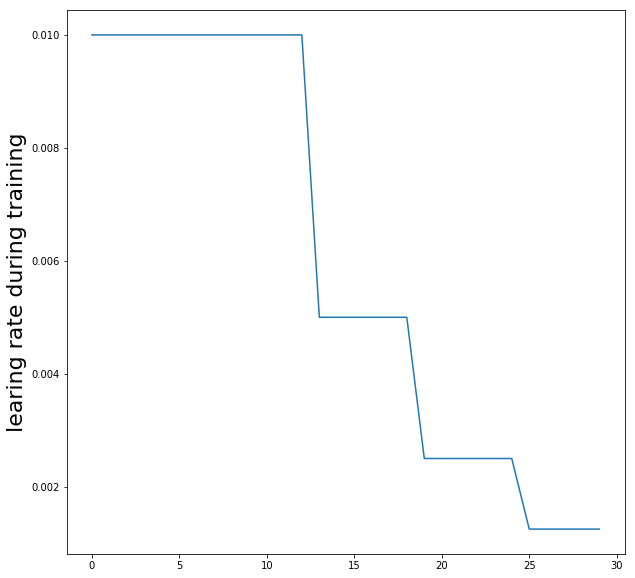

In [14]:
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in lr_rate_list])
plt.ylabel('learing rate during training', fontsize=22)
plt.show()

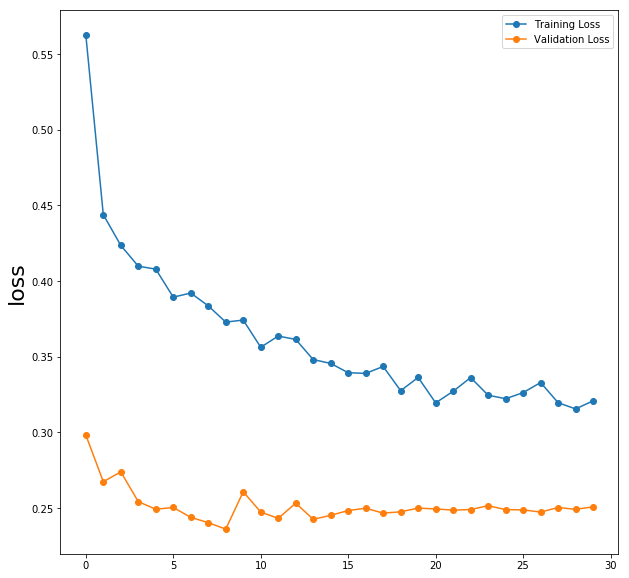

In [15]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

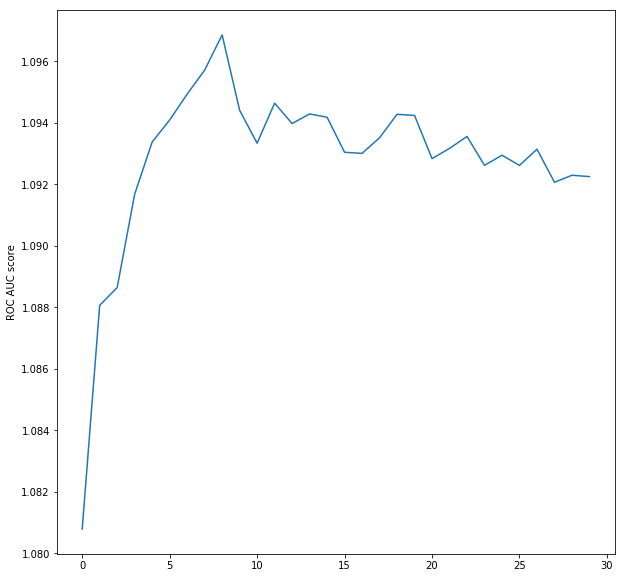

In [16]:
plt.figure(figsize=(10,10))
plt.plot(valid_roc_auc_list)
plt.ylabel('ROC AUC score')
plt.show()

# 3. Predict

In [17]:
model.load_state_dict(torch.load(f"{WEIGHT_PATH}/model_{VERSION}_best.pth"))
model.eval()
print('Prediction Starts here')

Prediction Starts here


# 4. Pseudo Labelling for Test Data

In [18]:
batch_size = batch_size
test_dataset = CloudDataset(df=sub_df,
                            datatype='test', 
                            img_ids=test_paths,
                            transforms=get_test_augmentation())

test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=N_JOBS)

In [19]:
y_preds = []
with torch.no_grad():

    bar = tqdm(test_loader)

    for data in bar:
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data = data.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        y_preds.append(output.to("cpu").data.numpy())
        
y_pred = np.vstack(y_preds).flatten()

100%|██████████| 54/54 [00:02<00:00, 19.97it/s]


In [20]:
def pseudo_labelling(x):
    if x < 0.2:
        return 0
    elif x > 0.8:
        return 1

sub_df[f'Pseudo{CLOUD_TYPE}'] = y_pred
sub_df['PseudoLabel'] = sub_df[f'Pseudo{CLOUD_TYPE}'].apply(pseudo_labelling)
sub_df.head()

,path,PseudoFlower,PseudoLabel
0,../input/resized_images/test_images_525/003832...,0.679355,NaN
1,../input/resized_images/test_images_525/006440...,0.353791,NaN
2,../input/resized_images/test_images_525/0078e5...,0.218000,NaN
3,../input/resized_images/test_images_525/008fc8...,0.758392,NaN
4,../input/resized_images/test_images_525/00a717...,0.543119,NaN


In [21]:
pseudo_df = train_df.copy()
pseudo_df_test = sub_df.copy()
pseudo_df_test_isna = pseudo_df_test[pseudo_df_test['PseudoLabel'].isna()].reset_index(drop=True)
pseudo_df_test = pseudo_df_test[pseudo_df_test['PseudoLabel'].notna()].reset_index(drop=True)
pseudo_df_test['PseudoLabel'] = pseudo_df_test['PseudoLabel'].astype(int)
pseudo_df_test = pseudo_df_test[['path', 'PseudoLabel']].rename(columns={'PseudoLabel':'hasMask'})
pseudo_df_test['from'] = 'test'
pseudo_df = pd.concat([pseudo_df, pseudo_df_test]).reset_index(drop=True)
print('####### Number of Test Data Decreased from {} to {}'.format(sub_df.shape[0], pseudo_df_test_isna.shape[0]))
pseudo_df.info()
pseudo_df.head(5)


####### Number of Test Data Decreased from 855 to 726
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 3 columns):
path       8518 non-null object
hasMask    8518 non-null int64
from       8518 non-null object
dtypes: int64(1), object(2)
memory usage: 199.7+ KB


,path,hasMask,from
0,../input/resized_images/train_images_525/00111...,1,train
1,../input/resized_images/train_images_525/002be...,1,train
2,../input/resized_images/train_images_525/0031a...,1,train
3,../input/resized_images/train_images_525/00352...,1,train
4,../input/resized_images/train_images_525/00399...,0,train


In [22]:
pseudo_df.to_csv(PATH+f'/pseudo_{CLOUD_TYPE}_{VERSION}.csv', index=False)
pseudo_df_test_isna[['path']].to_csv(PATH+f'/pseudo_test_{CLOUD_TYPE}_{VERSION}.csv', index=False)
